In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
trans_file = '/home/birniece/Documents/data/ANPERC_Lab/LargeRockBlock/DropBall_Test/big_rock_test6.csv'

In [3]:
df = pd.read_csv(trans_file, skiprows=9, index_col=0, header=None )
df.dropna(axis=1, inplace=True)
df.columns = ['R1','R2','R3','R4','R5','R6','R7','R8']
df.head()

,R1,R2,R3,R4,R5,R6,R7,R8
0,,,,,,,,
0.000000,0.003716,0.001599,0.001268,-0.000148,0.001587,0.001737,0.000697,0.000730
0.000010,0.003654,0.001683,0.001334,-0.000165,0.001550,0.001795,0.000730,0.000839
0.000019,0.003649,0.001658,0.001242,-0.000224,0.001643,0.001729,0.000738,0.000854
0.000029,0.003756,0.001669,0.001229,-0.000262,0.001768,0.001796,0.000870,0.000894
0.000038,0.003681,0.001612,0.001228,-0.000234,0.001775,0.001895,0.000738,0.000924


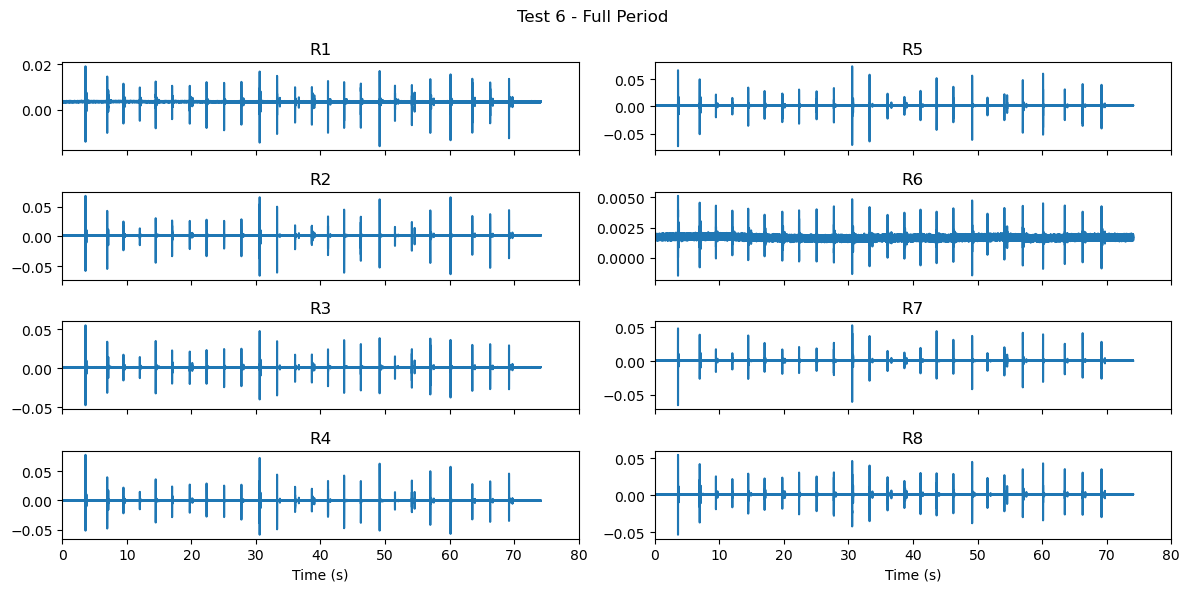

In [4]:
fig,axs = plt.subplots(4,2,figsize=[12,6], sharex=True)
axs[0,0].plot(df['R1'])
axs[1,0].plot(df['R2'])
axs[2,0].plot(df['R3'])
axs[3,0].plot(df['R4'])
axs[0,1].plot(df['R5'])
axs[1,1].plot(df['R6'])
axs[2,1].plot(df['R7'])
axs[3,1].plot(df['R8'])

axs[0,0].set_title('R1')
axs[1,0].set_title('R2')
axs[2,0].set_title('R3')
axs[3,0].set_title('R4')
axs[0,1].set_title('R5')
axs[1,1].set_title('R6')
axs[2,1].set_title('R7')
axs[3,1].set_title('R8')

for ax in axs[-1,:]:ax.set_xlabel('Time (s)'), ax.set_xlim([0,80])
    
fig.suptitle('Test 6 - Full Period ')
fig.tight_layout()

(3.553, 3.556)

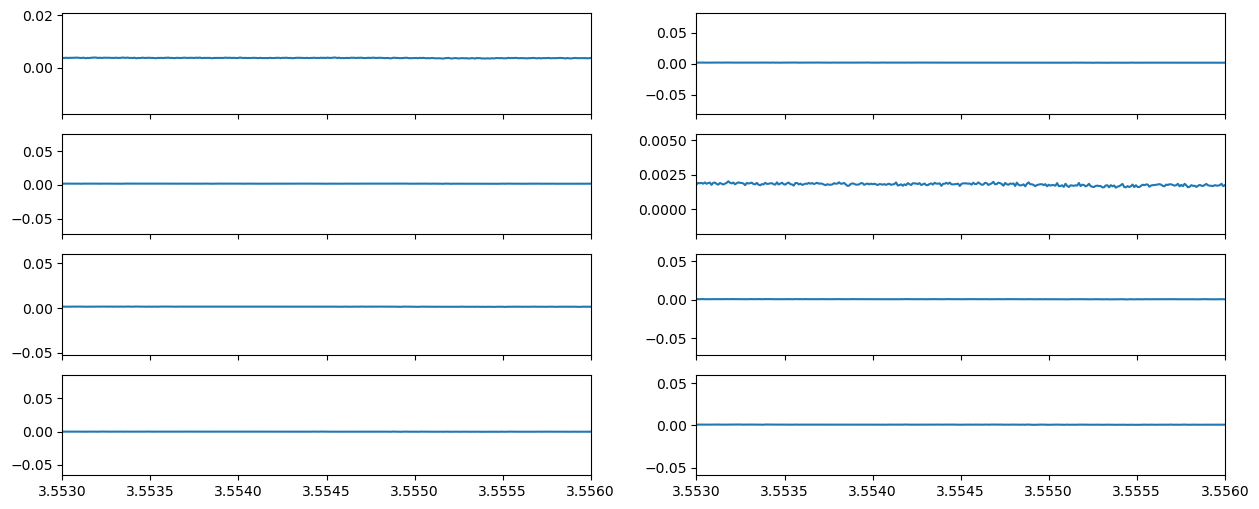

In [5]:
fig,axs = plt.subplots(4,2,figsize=[15,6], sharex=True)
axs[0,0].plot(df['R1'])
axs[1,0].plot(df['R2'])
axs[2,0].plot(df['R3'])
axs[3,0].plot(df['R4'])
axs[0,1].plot(df['R5'])
axs[1,1].plot(df['R6'])
axs[2,1].plot(df['R7'])
axs[3,1].plot(df['R8'])

axs[0,0].set_xlim([3.553,3.556])

# PUT INTO NUMPY ARRAY TO BE FASTER WORKING WITH

In [6]:
data = np.vstack([df['R1'].values, 
                  df['R2'].values,
                  df['R3'].values,
                  df['R4'].values,
                  df['R5'].values,
                  df['R6'].values,
                  df['R7'].values,
                  df['R8'].values,
                 ])

In [7]:
# Demean
data_dmn = data - np.tile(np.expand_dims(np.mean(data, axis=1),1),(1,data.shape[1]))


In [8]:
import obspy

In [9]:
def classic_sta_lta_py(a, nsta, nlta):
    """
    Computes the standard STA/LTA from a given input array a. The length of
    the STA is given by nsta in samples, respectively is the length of the
    LTA given by nlta in samples. Written in Python.

    .. note::

        There exists a faster version of this trigger wrapped in C
        called :func:`~obspy.signal.trigger.classic_sta_lta` in this module!

    :type a: NumPy :class:`~numpy.ndarray`
    :param a: Seismic Trace
    :type nsta: int
    :param nsta: Length of short time average window in samples
    :type nlta: int
    :param nlta: Length of long time average window in samples
    :rtype: NumPy :class:`~numpy.ndarray`
    :return: Characteristic function of classic STA/LTA
    """
    # The cumulative sum can be exploited to calculate a moving average (the
    # cumsum function is quite efficient)
    sta = np.cumsum(a ** 2, dtype=np.float64)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[nsta:] = sta[nsta:] - sta[:-nsta]
    sta /= nsta
    lta[nlta:] = lta[nlta:] - lta[:-nlta]
    lta /= nlta

    # Pad zeros
    sta[:nlta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

In [10]:
def get_triggers(stalta, thresh):
    trig = np.zeros_like(stalta)
    trig_on = np.zeros_like(stalta)
    trig_off = np.zeros_like(stalta)
    
    trig[np.where(stalta>thresh)]=1
    trig_on[np.where(np.diff(trig)==1)] = 1 

    
    return trig, trig_on, trig_off

In [19]:
array_stalta = np.zeros_like(data_dmn)
array_trigs = np.zeros_like(data_dmn)
for i,d in enumerate(data_dmn):
    array_stalta[i] = classic_sta_lta_py(d, nsta=25, nlta=2000)
    _, array_trigs[i], _ = get_triggers(array_stalta[i], thresh=25)



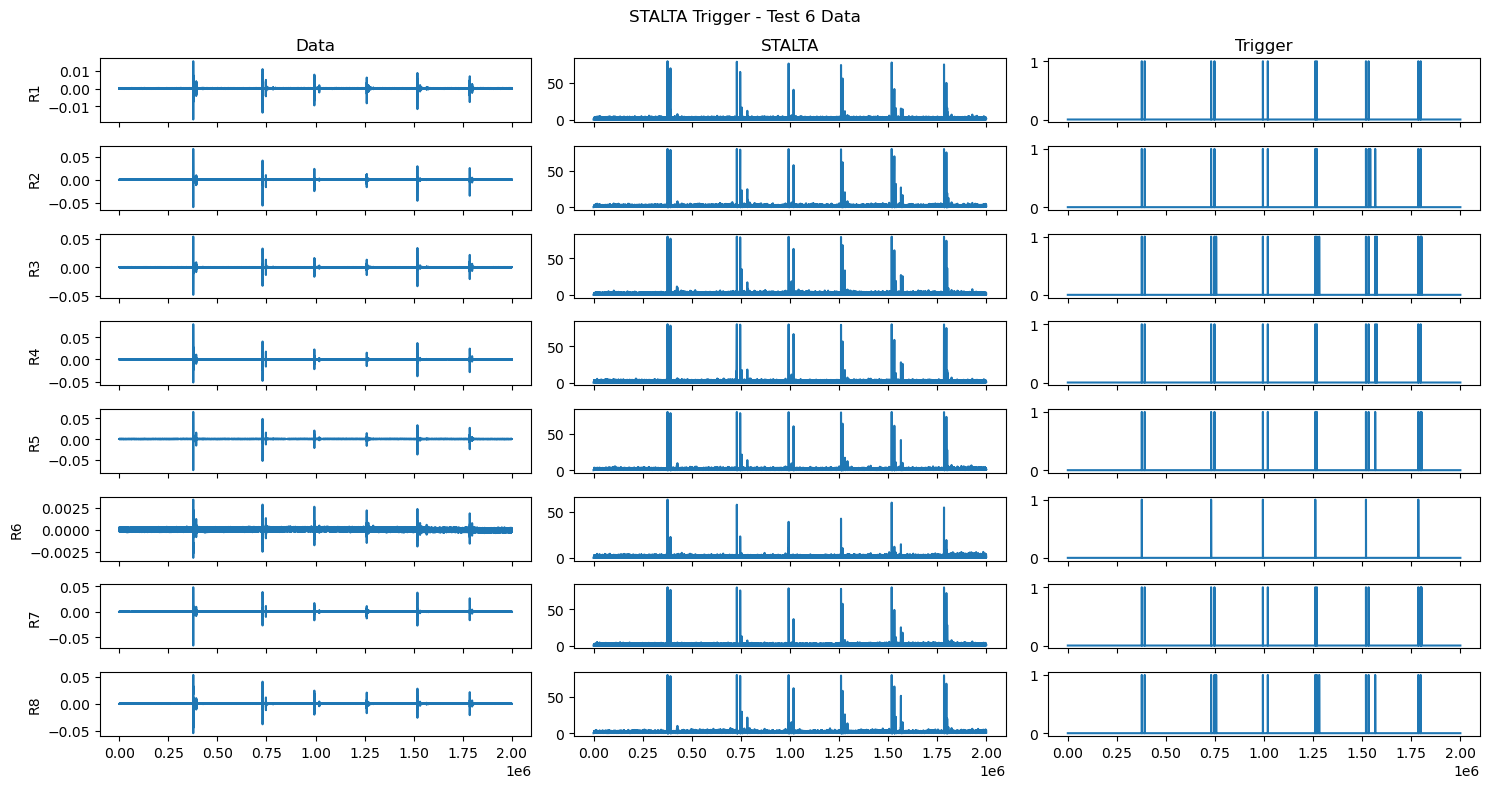

In [23]:
fig,axs = plt.subplots(8,3, figsize=[15,8], sharex=True)
for i,d in enumerate(data_dmn):
    axs[i,0].plot(d[:int(2e6)])
    axs[i,1].plot(array_stalta[i,:int(2e6)])
    axs[i,2].plot(array_trigs[i,:int(2e6)])
    axs[i,0].set_ylabel('R%i'%(i+1))

axs[0,0].set_title('Data')
axs[0,1].set_title('STALTA')
axs[0,2].set_title('Trigger')

fig.suptitle('STALTA Trigger - Test 6 Data')
fig.tight_layout()

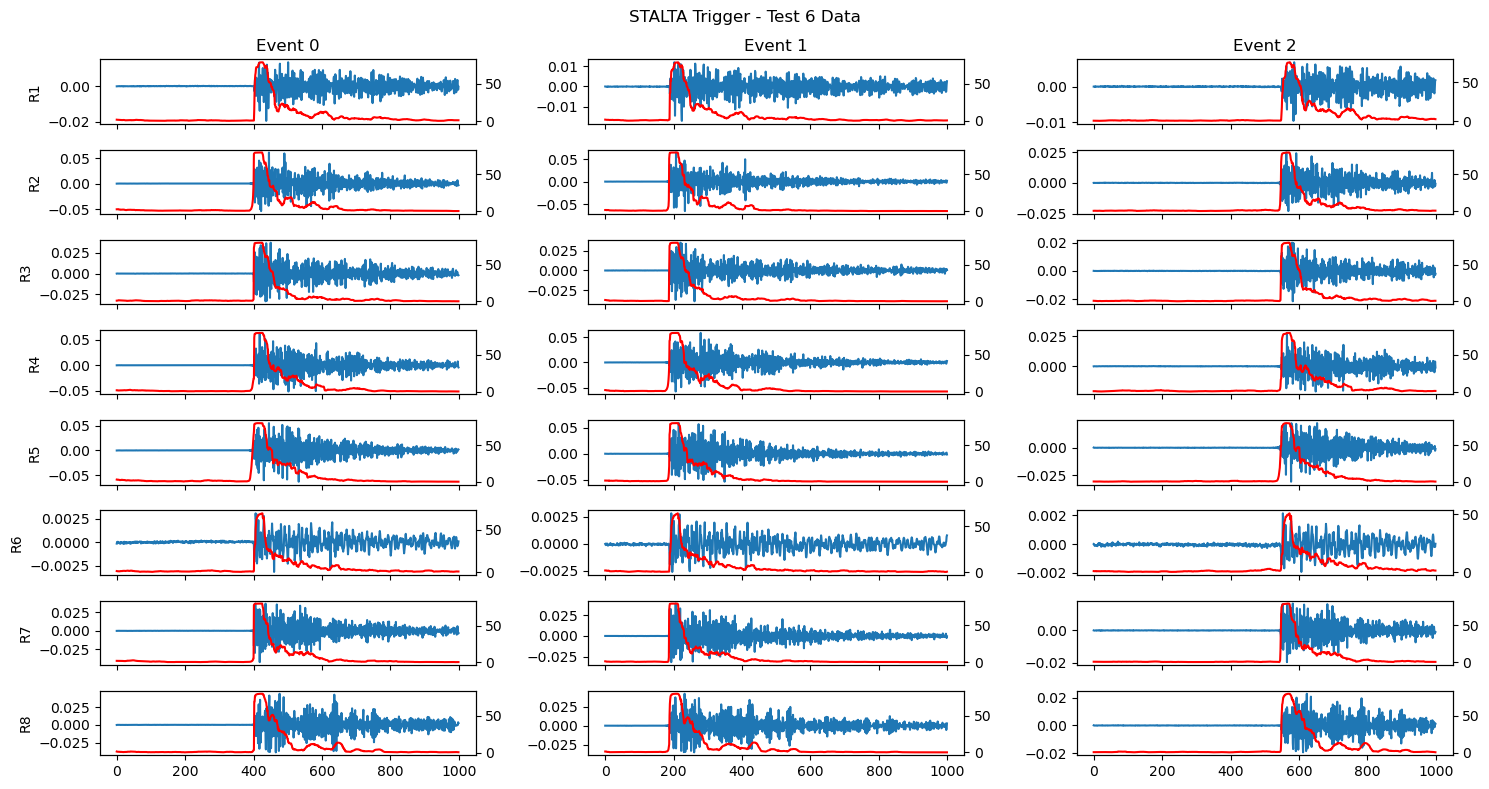

In [49]:
ev0_start_index = int(5.162e6)
ev0_end_index = int(5.163e6)

ev1_start_index = int(6.316e6)
ev1_end_index = int(6.317e6)

ev2_start_index = int(2.073e6)
ev2_end_index = int(2.074e6)

fig,axs = plt.subplots(8,3, figsize=[15,8], sharex=True)
for i,d in enumerate(data_dmn):
    ax0 = axs[i,0].twinx()
    axs[i,0].plot(d[ev0_start_index:ev0_end_index])
    ax0.plot(array_stalta[i,ev0_start_index:ev0_end_index],c='r')
    
    ax1 = axs[i,1].twinx()
    axs[i,1].plot(d[ev1_start_index:ev1_end_index])
    ax1.plot(array_stalta[i,ev1_start_index:ev1_end_index],c='r')

    
    ax2 = axs[i,2].twinx()
    axs[i,2].plot(d[ev2_start_index:ev2_end_index])
    ax2.plot(array_stalta[i,ev2_start_index:ev2_end_index],c='r')
    # ax2.plot(array_trigs[i,ev0_start_index:ev0_end_index],c='r')
    
    axs[i,0].set_ylabel('R%i'%(i+1))

axs[0,0].set_title('Event 0')
axs[0,1].set_title('Event 1')
axs[0,2].set_title('Event 2')

fig.suptitle('STALTA Trigger - Test 6 Data')
fig.tight_layout()

In [58]:
(0.007/1000)*125000

0.875

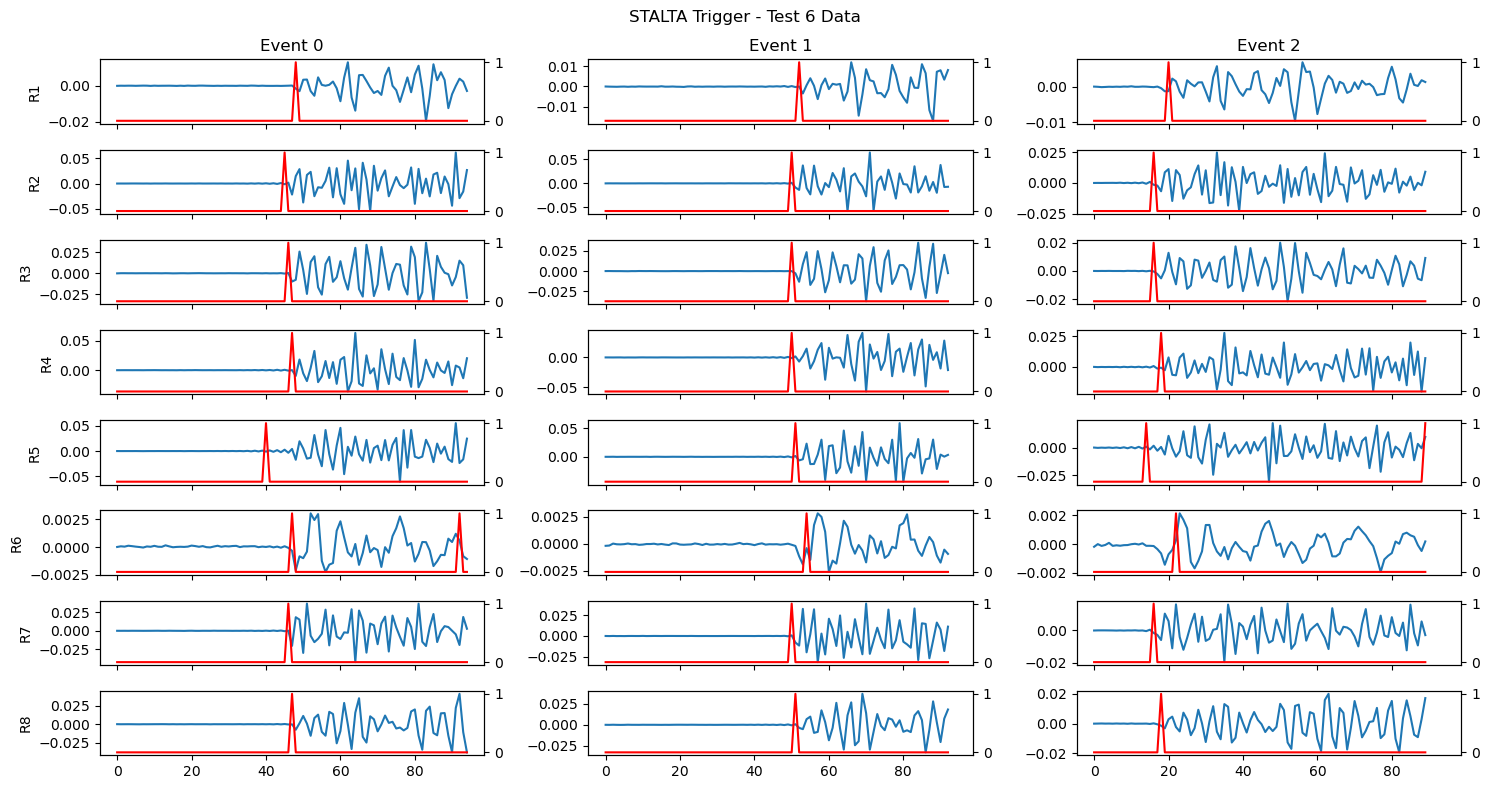

In [63]:
ev0_start_index = int(5.162354e6)
ev0_end_index = int(5.162449e6)

ev1_start_index = int(6.316136e6)
ev1_end_index = int(6.316229e6)

ev2_start_index = int(2.07353e6)
ev2_end_index = int(2.07362e6)

fig,axs = plt.subplots(8,3, figsize=[15,8], sharex=True)
for i,d in enumerate(data_dmn):
    ax0 = axs[i,0].twinx()
    ax0.plot(array_trigs[i,ev0_start_index:ev0_end_index],c='r')
    axs[i,0].plot(d[ev0_start_index:ev0_end_index])
    
    ax1 = axs[i,1].twinx()
    ax1.plot(array_trigs[i,ev1_start_index:ev1_end_index],c='r')
    axs[i,1].plot(d[ev1_start_index:ev1_end_index])

    
    ax2 = axs[i,2].twinx()
    ax2.plot(array_trigs[i,ev2_start_index:ev2_end_index],c='r')
    axs[i,2].plot(d[ev2_start_index:ev2_end_index])
    # ax2.plot(array_trigs[i,ev0_start_index:ev0_end_index],c='r')
    
    axs[i,0].set_ylabel('R%i'%(i+1))

axs[0,0].set_title('Event 0')
axs[0,1].set_title('Event 1')
axs[0,2].set_title('Event 2')

fig.suptitle('STALTA Trigger - Test 6 Data')
fig.tight_layout()

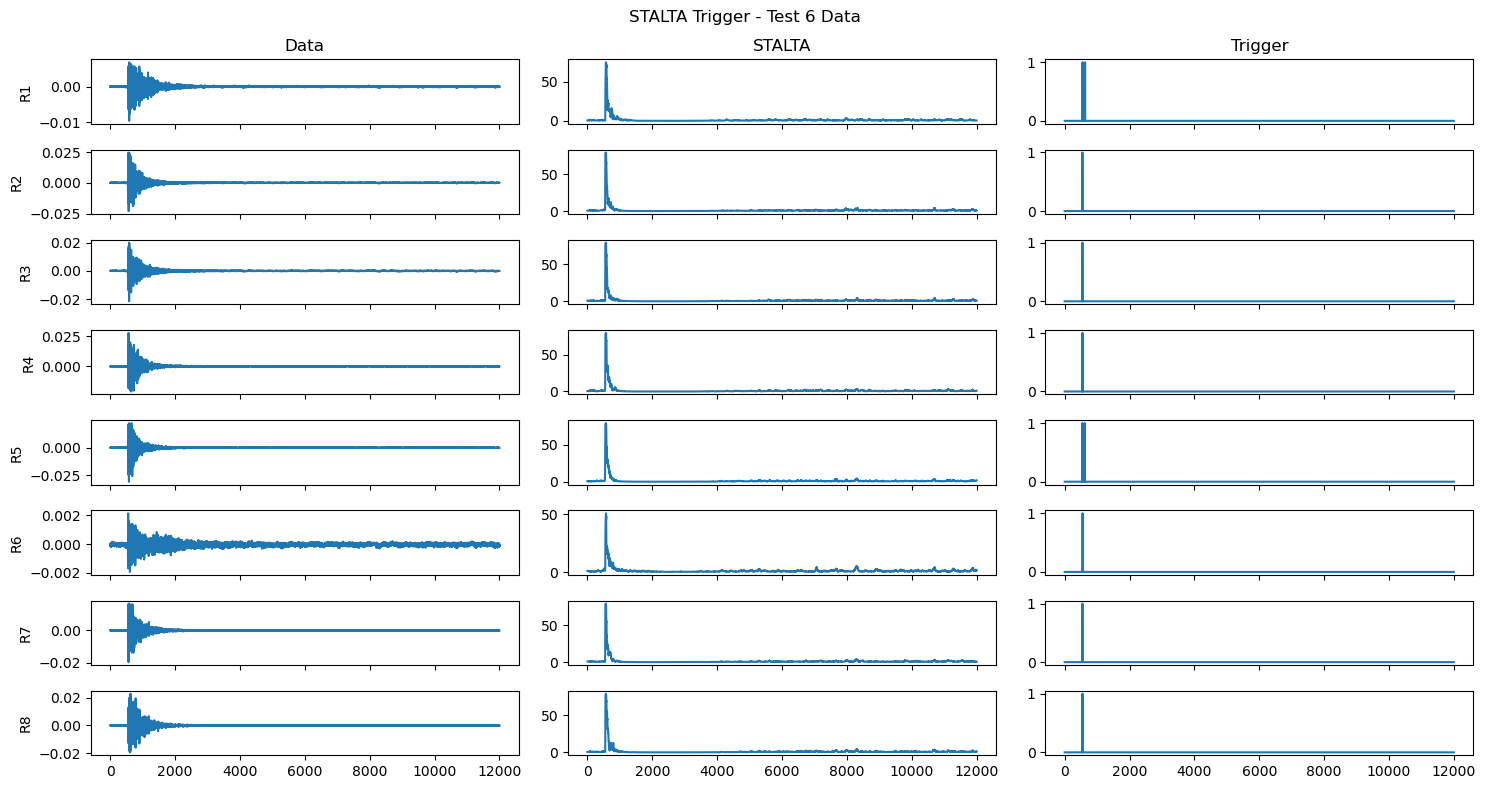

In [48]:
start_index = int(2.073e6)
end_index = int(2.085e6)

fig,axs = plt.subplots(8,3, figsize=[15,8], sharex=True)
for i,d in enumerate(data_dmn):
    axs[i,0].plot(d[start_index:end_index])
    axs[i,1].plot(array_stalta[i,start_index:end_index])
    axs[i,2].plot(array_trigs[i,start_index:end_index])
    axs[i,0].set_ylabel('R%i'%(i+1))

axs[0,0].set_title('Data')
axs[0,1].set_title('STALTA')
axs[0,2].set_title('Trigger')

fig.suptitle('STALTA Trigger - Test 6 Data')
fig.tight_layout()

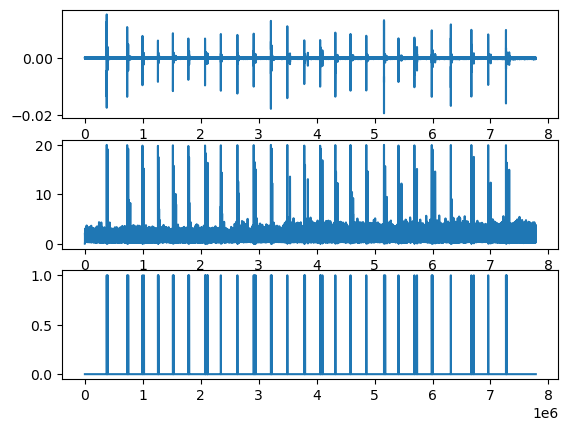

In [39]:
stalta = classic_sta_lta_py(data_dmn[0], nsta=50, nlta=1000)
trig, trig_on, trig_off = get_triggers(stalta, thresh=15)

fig,axs = plt.subplots(3,1)
axs[0].plot(data_dmn[0])
axs[1].plot(stalta)
axs[2].plot(trig_on)


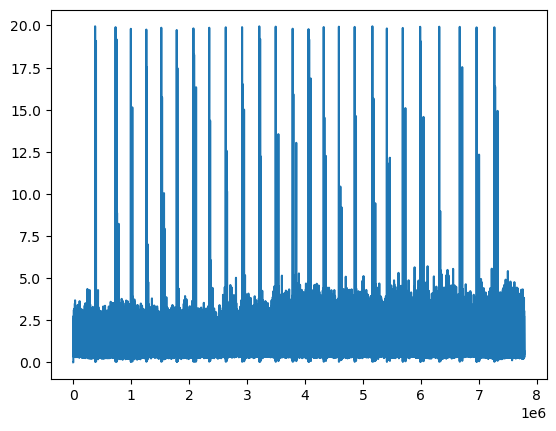

In [26]:
plt.plot(stalta)

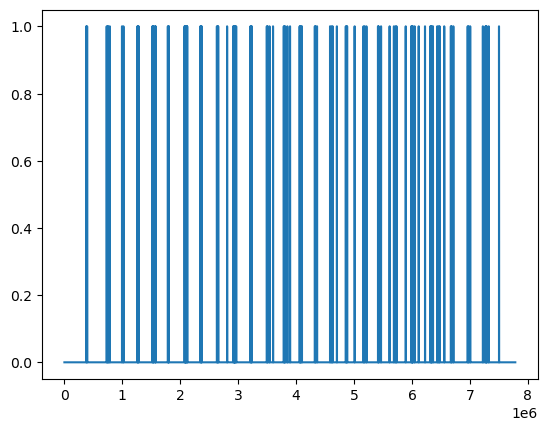

In [28]:
trig = np.zeros_like(stalta)
trig[np.where(stalta>5)]=1
plt.plot(trig)